In [1]:
import struct
import numpy as np
import matplotlib.pyplot as plt

In [2]:
filename = 'ofd.out'

data = {}
with open(filename, "rb") as f:
    # Title (256 characters)
    data["Title"] = f.read(256).decode("ascii", errors="ignore").rstrip("\x00")

    # Read multiple ints (15 in total). NN is 8-byte, so use 'q' instead of 'i'.
    fmt = "<iiiiiiiqiiiiiiiidii"
    sz = struct.calcsize(fmt)
    ints = struct.unpack(fmt, f.read(sz))
    (Nx, Ny, Nz, Ni, Nj, Nk, N0, NN,
     NFreq1, NFreq2, NFeed, NPoint, Niter, Ntime,
     Solver_maxiter, Solver_nout, Dt, NGline, IPlanewave) = ints[:19]

    # --- Read planewave_t ---
    # typedef struct {
    #    double theta, phi;
    #    double ei[3], hi[3];
    #    double ri[3], r0[3], ai;
    #    int pol;
    # } planewave_t;
    fmt = "2d 3d 3d 3d 3d d i"
    planewave = struct.unpack(fmt, f.read(struct.calcsize(fmt)))
    data["Planewave"] = planewave

    fmt = "i"
    temp = struct.unpack(fmt, f.read(struct.calcsize(fmt)))
    
    # --- Read arrays with numpy ---
    def read_array(dtype, count):
        byte_size = np.dtype(dtype).itemsize * count
        return np.frombuffer(f.read(byte_size), dtype=dtype, count=count)

    data["Xn"] = read_array(np.float64, Nx + 1)
    data["Yn"] = read_array(np.float64, Ny + 1)
    data["Zn"] = read_array(np.float64, Nz + 1)

    data["Xc"] = read_array(np.float64, Nx)
    data["Yc"] = read_array(np.float64, Ny)
    data["Zc"] = read_array(np.float64, Nz)

    data["Eiter"] = read_array(np.float64, Niter)
    data["Hiter"] = read_array(np.float64, Niter)

    data["VFeed"] = read_array(np.float64, NFeed * (Solver_maxiter + 1))
    data["IFeed"] = read_array(np.float64, NFeed * (Solver_maxiter + 1))
    data["VPoint"] = read_array(np.float64, NPoint * (Solver_maxiter + 1))

    data["Freq1"] = read_array(np.float64, NFreq1)
    data["Freq2"] = read_array(np.float64, NFreq2)

    # --- Read feed_t ---
    # feed_t {
    #    char dir; int i,j,k; double dx,dy,dz; double volt; double delay; double z0;
    # }
    feed_fmt = "c 3i 3d 3d"
    feed_size = struct.calcsize(feed_fmt)
    Feed = []
    for _ in range(NFeed):
        Feed.append(struct.unpack(feed_fmt, f.read(feed_size)))
    data["Feed"] = Feed

    # complex (double,double)
    data["Zin"] = read_array(np.complex128, NFeed * NFreq1)
    data["Ref"] = read_array(np.float64, NFeed * NFreq1)

    data["Pin0"] = read_array(np.float64, NFeed * NFreq2)
    data["Pin1"] = read_array(np.float64, NFeed * NFreq2)

    data["Spara"] = read_array(np.complex128, NPoint * NFreq1)
    data["Gline"] = read_array(np.float64, NGline * 2 * 3)

    # --- Surface ---
    NSurface = struct.unpack("i", f.read(4))[0]

    # typedef struct { double nx,ny,nz,x,y,z,ds; } surface_t;
    surf_fmt = "7d"
    surf_size = struct.calcsize(surf_fmt)
    Surface = []
    for _ in range(NSurface):
        Surface.append(struct.unpack(surf_fmt, f.read(surf_size)))
    data["Surface"] = Surface

    # SurfaceEx/Ey/Ez/Hx/Hy/Hz (complex)
    SurfaceData = {}
    for ifreq in range(NFreq2):
        SurfaceData[ifreq] = {
            "Ex": read_array(np.complex128, NSurface),
            "Ey": read_array(np.complex128, NSurface),
            "Ez": read_array(np.complex128, NSurface),
            "Hx": read_array(np.complex128, NSurface),
            "Hy": read_array(np.complex128, NSurface),
            "Hz": read_array(np.complex128, NSurface),
        }
    data["SurfaceFields"] = SurfaceData

    # --- cEx_r etc (float) ---
    c_fields = {}
    for ifreq in range(NFreq2):
        c_fields[ifreq] = {
            "Ex_r": read_array(np.float32, NN),
            "Ex_i": read_array(np.float32, NN),
            "Ey_r": read_array(np.float32, NN),
            "Ey_i": read_array(np.float32, NN),
            "Ez_r": read_array(np.float32, NN),
            "Ez_i": read_array(np.float32, NN),
            "Hx_r": read_array(np.float32, NN),
            "Hx_i": read_array(np.float32, NN),
            "Hy_r": read_array(np.float32, NN),
            "Hy_i": read_array(np.float32, NN),
            "Hz_r": read_array(np.float32, NN),
            "Hz_i": read_array(np.float32, NN),
        }
    data["cfield"] = c_fields

    # Last number (num)
    data["num_written"] = struct.unpack("Q", f.read(8))[0]

NSurface 5400
NPoint 0
NFeed 0
NGline 12
Freq1 3e9
Freq2 3e9
Planewave.ai 9.4488e+09
Planewave.pol 1

In [8]:
len(c_fields[0]["Ex_i"])

35937

In [9]:
33*33*33


35937

In [5]:
Ex_zx = np.zeros((Nx+3, Nz+3), dtype=np.complex128)
Ex_zy = np.zeros((Ny+3, Nz+3), dtype=np.complex128)
Ex_yx = np.zeros((Nx+3, Ny+3), dtype=np.complex128)
iy = 16
for iz in range(Nz+3):
    for ix in range(Nx+3):
        Ex_zx[ix, iz] = complex(c_fields[0]["Ex_r"][iz*(Nx+3)*(Ny+3)+iy*(Nx+3)+ix], 
                                c_fields[0]["Ex_i"][iz*(Nx+3)*(Ny+3)+iy*(Nx+3)+ix])

ix = 16
for iz in range(Nz+3):
    for iy in range(Ny+3):
        Ex_zy[iy, iz] = complex(c_fields[0]["Ex_r"][iz*(Nx+3)*(Ny+3)+iy*(Nx+3)+ix],
                                c_fields[0]["Ex_i"][iz*(Nx+3)*(Ny+3)+iy*(Nx+3)+ix])

iz = 16
for ix in range(Nx+3):
    for iy in range(Ny+3):
        Ex_yx[ix, iy] = complex(c_fields[0]["Ex_r"][iz*(Nx+3)*(Ny+3)+iy*(Nx+3)+ix],
                                c_fields[0]["Ex_i"][iz*(Nx+3)*(Ny+3)+iy*(Nx+3)+ix])


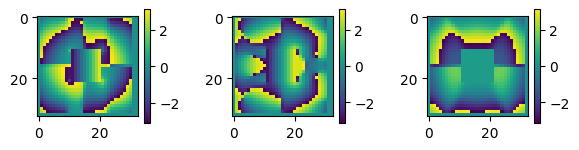

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 6))
im1 = axes[0].imshow(np.angle(Ex_zx))
fig.colorbar(im1, ax=axes[0], shrink=0.2)
im2 = axes[1].imshow(np.angle(Ex_zy))
fig.colorbar(im2, ax=axes[1], shrink=0.2)
im3 = axes[2].imshow(np.angle(Ex_yx))
fig.colorbar(im3, ax=axes[2], shrink=0.2)
plt.tight_layout()
plt.show()

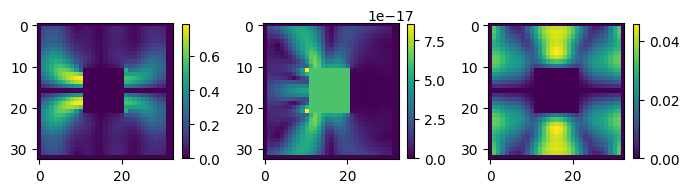

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(7, 7))
im1 = axes[0].imshow(np.abs(Ex_zx))
fig.colorbar(im1, ax=axes[0], shrink=0.2)
im2 = axes[1].imshow(np.abs(Ex_zy))
fig.colorbar(im2, ax=axes[1], shrink=0.2)
im3 = axes[2].imshow(np.abs(Ex_yx))
fig.colorbar(im3, ax=axes[2], shrink=0.2)
plt.tight_layout()
plt.show()

In [55]:
np.angle(1+1j)

np.float64(0.7853981633974483)

In [68]:
3e8/3e9


0.1

In [71]:
0.3/30


0.01